# Objectives

We are using the UCI Heart Disease Data from Kaggle in the file data/raw/heart.csv
https://www.kaggle.com/ronitf/heart-disease-uci

It has 14 columns, 13 potential feature variables and one boolean target variable, which is the diagnosis of coronary artery disease based on angiography, so we are doing a logistic regression or classification problem.

In this notebook we will do exploratory data analysis to characterize the data and select candidate features to explain the target.

# 1. Load the data from data/heart.csv

In [28]:
#Import pandas, matplotlib.pyplot, and seaborn 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import math
#import os

from library.sb_utils import save_file

In [2]:
heart_data = pd.read_csv("../data/heart.csv")
heart_data.info()
heart_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         303 non-null    int64  
 1   Sex         303 non-null    int64  
 2   ChestPain   303 non-null    int64  
 3   SystolicBP  303 non-null    int64  
 4   Chol        303 non-null    int64  
 5   Glucose     303 non-null    int64  
 6   RestECG     303 non-null    int64  
 7   STMaxRate   303 non-null    int64  
 8   STPain      303 non-null    int64  
 9   STWave      303 non-null    float64
 10  STSlope     303 non-null    int64  
 11  NumColor    303 non-null    int64  
 12  Defects     303 non-null    int64  
 13  AngioTgt    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


,Age,Sex,ChestPain,SystolicBP,Chol,Glucose,RestECG,STMaxRate,STPain,STWave,STSlope,NumColor,Defects,AngioTgt
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Data availability and types

All 14 columns have data in all 303 rows.  No missing data.
Only 1 floating point column - STWave.  The rest are all integers.  


# 2. Correlations of the variables

During the Data Wrangling phase, we examined the distributions of each raw data variable and found manuy of them to be categorical or ordinal variables with 2 to 5 values and a few of them to be continuous variables with orderly distributions.

Now let's look at the Pearson correlations of the candidate features to the target (coronary artery blockage measured by angiography)

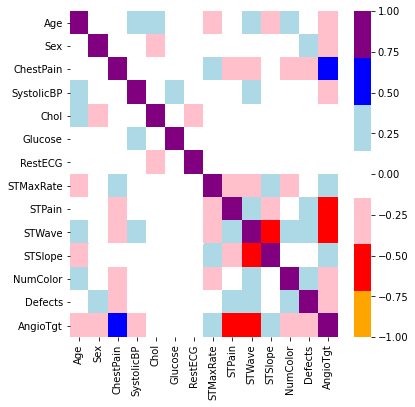

In [3]:
#Show a seaborn heatmap of correlations
plt.subplots(figsize=(6,6))
sns.heatmap(heart_data.corr(), vmin=-1, cmap=['orange','red','pink','white','lightblue','blue', 'purple']);

No strongly positive correlations (purple) to the target or each other and a good deal of moderately negative correlations (red).  Note the correlation scale on the right of the diagram. Some of these seem counterintuitive.  

Let's look at the variables again to see which are positive toward heart disease (as the target is 1=disease, 0=no) and which are inverted.  Then we'll note the expected correlation and lastly whether that expectation was CONFIRMED, REVERSED, UNCORRELATED, or there's an unexpected correlation.

* Age - older is bigger. presumably positive (older individuals more likely to have it) but maybe not, as cardiac patients might die off faster than aging people develop it.  MILDLY REVERSED
* Sex - 0 female, 1 male.  presumably positive as males have a higher heart disease rate than females, but maybe not depending on how the sample was built.  MILDLY REVERSED
* ChestPain - uncertain direction (is 0 or 3 no pain?, forms of pain are not ordered). no expectation. POSITIVE
* SystolicBP - positive direction (higher is worse). expected positive.  MILDLY REVERSED
* Chol      - positive direction.  expected positive.  UNCORRELATED
* Glucose   - positive direction.  expected positive.  UNCORRELATED
* RestECG   - positive direction (0=normal, 1=abnormal, 2=probable hypertrophy). expected positive. UNCORRELATED
* STMaxRate - uncertain (is it bad your heart raced more, or does it show your heart can handle it?). uncertain.  MILD POSITIVE
* STPain    - positive direction. expected positive.  REVERSED
* STWave    - generally positive. expected positive.  REVERSED
* STSlope   - uncertain. no expectation. MILD POSITIVE
* NumColor - negative direction.  expected very negative correlation to narrowing in angiogram.  MILDLY CONFIRMED
* Defects   - positive direction. expected positive. MILDLY REVERSED

Well, that's a fine kettle of fish.  It seems the factors we expected to be bad actually have mostly negative correlations to the angiogram diagnosis.  Is the heart disease target reversed from the advertised values?  

Let's look at scatter plots of some interesting pairs.

In [5]:
# define useful function to create scatterplots with regression line, thicker with increasing r^2 
def scatterplots(columns, ycol=None, ncol=None, figsize=(15, 15), data=heart_data):
    if ncol is None:
        ncol = len(columns)
    if ycol is None:
        ycol = 'AngioTgt'
    nrow = int(np.ceil(len(columns) / ncol))
    fig, axes = plt.subplots(nrow, ncol, figsize=figsize) #, squeeze=False)
    fig.subplots_adjust(wspace=0.5, hspace=0.6)
    for i, col in enumerate(columns):
        ax = axes.flatten()[i]
        x = np.array(data[col]).reshape((-1, 1))
        y = np.array(data[ycol])
        try:
            mask = np.isnan(x)
            x[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), x[~mask])
        except TypeError:
            print("%s is a non-numeric type." % col)

        ax.scatter(x = col, y = ycol, data=data, alpha=0.5)
        ax.set(xlabel=col, ylabel=ycol)
        
        try:
            # Initialize and train a regression model
            model =LinearRegression().fit(x, y)
            r_sq = model.score(x, y)
            # Predict
            y_predicted = model.predict(x)
            ax.plot(np.array(data[col]).reshape((-1,1)), y_predicted, color='r', linewidth=r_sq*4)
        except ValueError:
            print ("Could not run a linear regression on %s" % col)
                       
    nsubplots = nrow * ncol    
    for empty in range(i+1, nsubplots):
        axes.flatten()[empty].set_visible(False)

### Reversed Correlation of Feature to Target

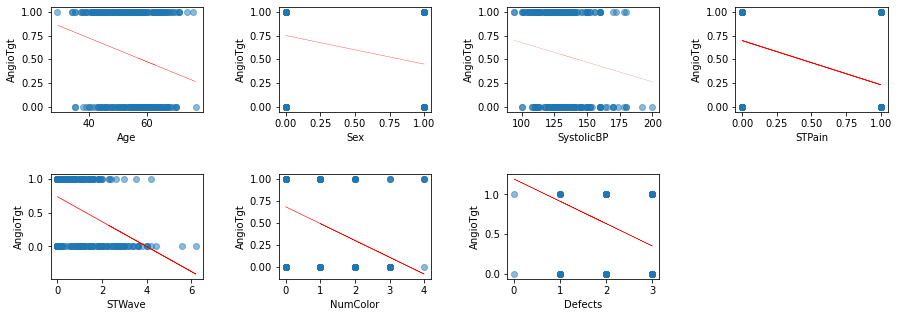

In [6]:
## Factors expected to contribute to heart disease which show a negative Pearson correlation:
features = ['Age','Sex','SystolicBP','STPain','STWave','NumColor','Defects']
scatterplots(features, ycol='AngioTgt', ncol=4, figsize=(15, 5))

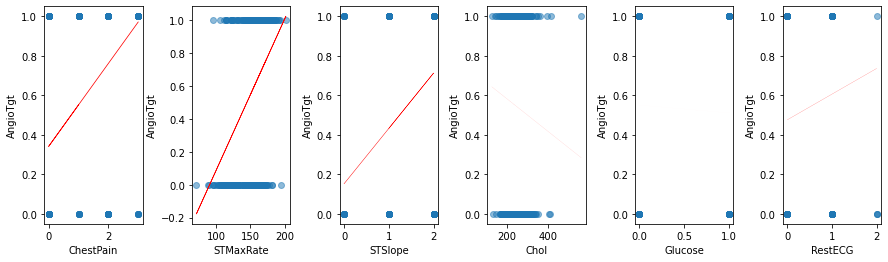

In [59]:
# 3 Candidate features with positive correlation and 3 uncorrelated to the AngioTgt
features = ['ChestPain','STMaxRate','STSlope','Chol','Glucose','RestECG']
scatterplots(features, ycol='AngioTgt', figsize=(15, 4))

STWave and STSlope showed a moderate negative correlation to each other in the correlation heat map.  Let's look at their correlation also.

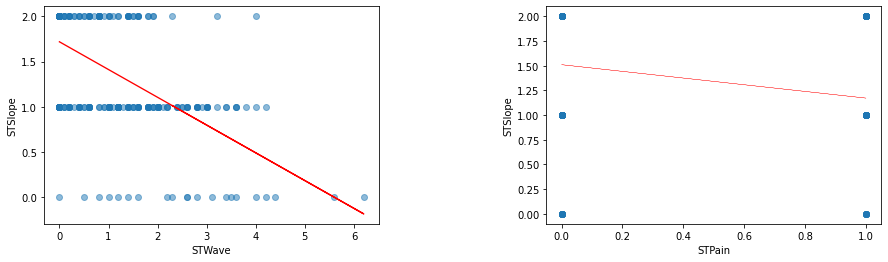

In [66]:
scatterplots(['STWave','STPain'], ycol='STSlope', figsize=(15, 4))

While there is a correlation with a strong R^2 between STSlope and STWave, the vast majority of points lie well off the estimate line and there's no opportunity to substitute one for the other, so we will use them both in the Feature Engineering phase.

Linear regressions against the target agree with the Pearson correlation coefficient, with perhaps greater discrimination.  
* STMaxRate and STSlope are positively correlated with the angiogram target.
* Chol, Glucose, and RestECG are uncorrelated with the target.
* Age, Sex, and SystolicBP are mildly negatively correlated.
* STPain, STWave, NumColor and Defects are negatively correlated.

Only 3 of these seem correct!  Could the target be backwards?

Assuming that these categorical variables are ordered and using (continuous) linear regression techniques does not lead to sensible relationships.

We'll have to look at each category of these categoricals and see if we can make sense of them.

# 3. Breaking down the categoricals

### STPain (Angina Pain induced by the stress test)

<AxesSubplot:xlabel='STPain', ylabel='count'>

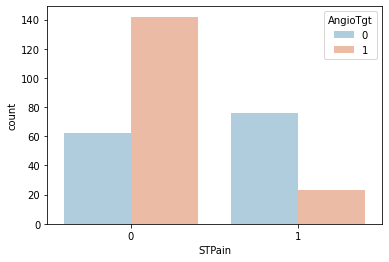

In [15]:
# STPain (chest pain during the stress test) boolean vs. Angiogram Target boolean
sns.countplot(hue='AngioTgt', x='STPain', data=heart_data, palette='RdBu_r')

According to this data, subjects with coronary artery disease overwhelmingly did NOT report angina pain during the stress test. 

In fact, roughly 70% of those not reporting pain are positive and only 20% of those reporting pain during the stress test are positive for the disease.  

Like the quantitative visualizations said, STPain is a negative indicator of heart disease (as measured by coronary artery narrowing).

### STWave (descriptive categories of the ECG wave changes during the stress test)

<AxesSubplot:xlabel='STWave', ylabel='count'>

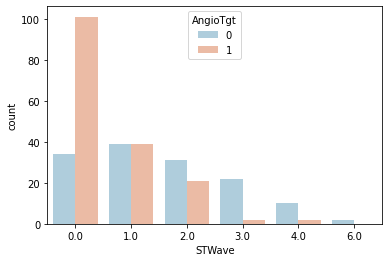

In [14]:
# STWave (heart wave changes during the stress test) float vs. Angiogram Target boolean
sns.countplot(hue=heart_data['AngioTgt'], x=round(heart_data['STWave'],0), palette='RdBu_r')


STWave has 1 decimal place in the data, despite the description in the source stating it only has a few integer values.  There is no information available to explain what the decimals mean, but using round() to group them into integers, we see that 0 is a very strong indicator of heart disease and values of 2 or more indicate no heart disease (<50% narrowing).  

STWave is another negative indicator.  

If we make it a boolean, on which side of 1, should we make the threshold?  Rounding above is really saying that 0.5 is a break-even point and 1.5 is a mild no.


<AxesSubplot:xlabel='STWave', ylabel='count'>

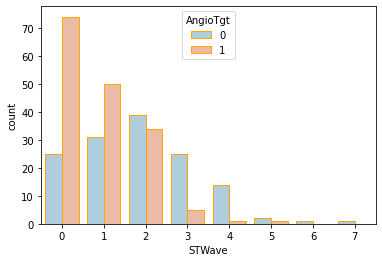

In [53]:
#sns.countplot(hue=heart_data['AngioTgt'], x=heart_data['STWave'].apply(math.floor), palette='YlGn', edgecolor='Purple')
sns.countplot(hue=heart_data['AngioTgt'], x=heart_data['STWave'].apply(math.ceil), palette='RdBu_r',edgecolor='Orange', dodge=True)

Looking at the above graphs one at a time, the floor function shows us that exactly 1 up to 1.9 is a slight negative, while 0 to 0.9 is a strong positive.  The ceiling function shows us that 0.1 to 1.0 is a positive and 1.1 to 2.0 is a slight negative. So if we make STWave a boolean feature, we will break it on the right side of 1.  

STWave > 1 is a negative and STWave <= 1 is a positive.

### NumColor (Number of coronary vessels colored in fluoroscopy)

<AxesSubplot:xlabel='NumColor', ylabel='count'>

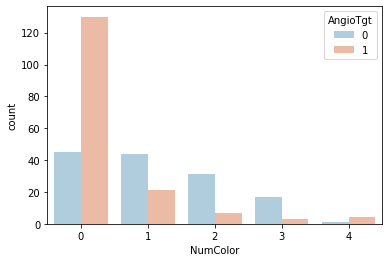

In [43]:
# NumColor (Number of coronary vessels showing bright color) integer vs. Angiogram Target boolean
sns.countplot(hue=heart_data['AngioTgt'], x=heart_data['NumColor'], palette='RdBu_r')

Zero coronary vessels colored by fluoroscopy is a good indicator of the target coronary artery narrowing.  About 75% of subjects with NumColor = 0 have been diagnosed as having heart disease (>50% narrowing).  One, two or three vessels colored indicates a better than 66% chance of not having heart disease (<50% narrowing).

Apparently good blood flow is indicated by the color.  This makes the candidate feature NumColor also negatively correlated to AngioTgt.

Let's make this a boolean feature.  NumColor=0 is a True indicator of disease, and the other values are False.

### Defects  (Thalium Test: Normal, Fixed Defect, Reversible Defect)


<AxesSubplot:xlabel='Defects', ylabel='count'>

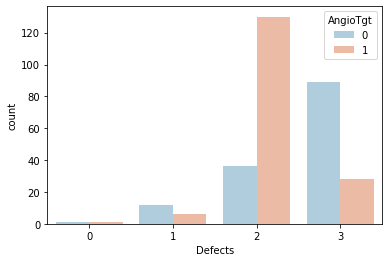

In [42]:
# Defects (Normal, fixed or reversible defect according to thalium test) integer vs. Angiogram Target boolean
sns.countplot(hue=heart_data['AngioTgt'], x=heart_data['Defects'], palette='RdBu_r')

The source description gives three labels: Normal, Fixed Defect and Reversible Defect.

Could conjecture a mapping between those, but the only mapping that is known and important is that a value of 2 associates with heart disease in more than 75% of the subjects.  Follow the data.

Let's make this a boolean feature:  Defects=2 is a True indication for disease and the others are False.

### ChestPain (Not during the stress test, Typical Angina, Atypical Angina, Non-Anginal Pain, Asymptomatic)


<AxesSubplot:xlabel='ChestPain', ylabel='count'>

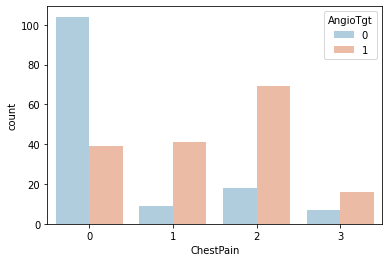

In [60]:
# ChestPain (Not during the stress test, Typical Angina, Atypical Angina, Non-Anginal Pain, Asymptomatic) cat vs. AntioTgt bool
sns.countplot(hue=heart_data['AngioTgt'], x=heart_data['ChestPain'], palette='RdBu_r')

The source description says the original values are 1-4, with 4 being Asymptomatic.  This graph strongly suggests that Asymptomatic was mapped to 0, as an ordinal (ordered categorical) should be.

The association with heart disease is not linearly, nor even monotonically, increasing but we can definitely say that 0 is associated with AngioTgt = False and 1, 2, and 3 are all associated with AngioTgt=True.

### STSlope (Peak Exercise ST Segment Slope)

<AxesSubplot:xlabel='STSlope', ylabel='count'>

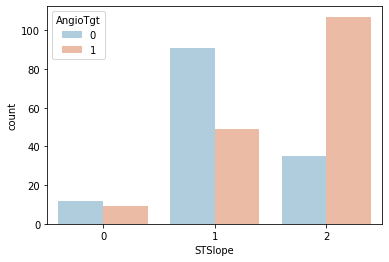

In [54]:
#STSlope (Peak Exercise ST Segment Slope) three values vs. AngioTgt boolean
sns.countplot(hue=heart_data['AngioTgt'], x=heart_data['STSlope'], palette='RdBu_r')

Like Linear Regression told us, STSlope has a positive correlation to the target.  2 is a positive, 0 and 1 are negatives.

### Glucose (Fasting Blood Sugar > 120) boolean

<AxesSubplot:xlabel='Glucose', ylabel='count'>

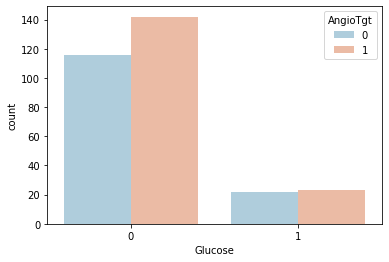

In [56]:
### Glucose (Fasting Blood Sugar > 120) boolean vs. AngioTgt boolean
sns.countplot(hue=heart_data['AngioTgt'], x=heart_data['Glucose'], palette='RdBu_r')

Diabetes (Glucose True) is uncorrelated with the target in these subjects and no diabetes is paradoxically a slight positive indicator of AngioTgt.  Neither value tells us much and the one that tells us a little is probably just explained by the small sample size (303) of this data.

The Glucose variable is not a promising feature for this model.

### RestECG (Normal ECG, ST wave abnormality, Evidence of Left Ventricular Hypertrophy)


<AxesSubplot:xlabel='RestECG', ylabel='count'>

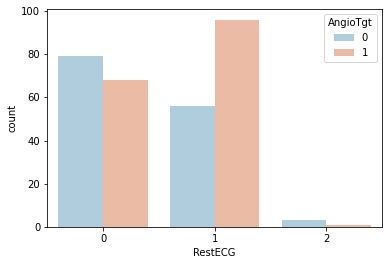

In [57]:
### RestECG (Normal ECG, ST wave abnormality, Evidence of Left Ventricular Hypertrophy) categorical vs. AngioTgt boolean
sns.countplot(hue=heart_data['AngioTgt'], x=heart_data['RestECG'], palette='RdBu_r')

While the three values of RestECG sound ordered, the middle one (ST Wave abnormality) shows more subjects with heart disease, but the highest does not.  In fact there are very few subjects with a value of 2.

So this candidate feature should be treated as a boolean with RestECG=1 treated as a True and 0 and 2 treated as False.

# 4. Candidate Features

Here are the candidate features to use for Feature Engineering:

### Good Continuous Numerical Feature Candidate

* STMaxRate is positively related to AngioTgt.

### Good Categorical Feature Candidates

* STPain is surprisingly negatively related to AngioTgt.  Boolean: 0 -> True Target, 1 -> False Target
* STWave is negatively related to AngioTgt.    Boolean: STWave > 1 -> False Tgt, STWave <= 1 -> True Target
* NumColor is negatively related to AngioTgt.  Boolean: NumColor==0 -> TrueTgt, NumColor > 0 -> False Target
* Defects is an unordered category.            Boolean: Defects==2 -> True Tgt, Defects != 2 -> False Target
* ChestPain is positively related to AngioTgt! Boolean: ChestPain==0 -> False Tgt, ChestPain > 0 -> True Target
* STSlope is positively related to AngioTgt.   Boolean: STSlope==2 -> True Tgt, STSlope < 2 -> False Target
* RestECG is an unordered category.            Boolean: RestECG==1 -> True Tgt, RestECG != 1 -> False Target

### Marginal Continuous Feature Candidate

* Age is surprisingly and mildly negatively related to AngioTgt.

### Poor Continuous Feature Candidates

* SystolicBP is surprisingly and weakly negatively related to AngioTgt.
* Cholesterol is surprisingly and very weakly negatively related to AngioTgt.

### Poor Categorical Feature Candidates

* Sex is surprisingly and weakly negatively related to AngioTgt.
* Glucose (>120 or Diabetic) is surprisingly not related to AngioTgt.

